## AIMLCZG513 Advanced Deep Learning - ADL
### ADLGroup12 - Assignment - 1
### Group Members
1. C RAMAKRISHNA (2023ab05177)
2. KASHYAP RAJPUROHIT (2023ab05027)
3. SAYANTA CHATTERJEE (2023aa05173)
4. KHAN MOHAMMED SAMEER SHAHNAVAZ (2023aa05795)

Note: All members equally contributed to this assignment.

### Problem Statement

This assignment is about feature extraction via dimensionality reduction using variants of autoencoders.  Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images! Use randomly selected 70% of the dataset as training set and remaining 30% as the test set.

**Task 1:** Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

**Task 2:** Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.

**Task 3:** Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?

**Task 4:** Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as

   1
1    1
   1    
1     1
   1

7 will be "classified" as
   1
0    1
   0    
0    1
   0

Generate the confusion matrix for the corresponding test dataset.

**Importing Libraries & cifar10 Dataset**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import keras.layers as layers

from keras import Input, Model, Sequential
from keras.datasets import cifar10
from keras.ops.image import rgb_to_grayscale
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

**Load Dataset & split into train and test datasets**

In [ ]:
# load dataset
(org_train,y_train), (org_test,y_test) = cifar10.load_data() # returns color image , pixel range[0-255]

# combine dataset to prepare for training
org_train = np.vstack((org_train, org_test))
y_train = np.vstack((y_train, y_test)).ravel()

# convert to grayscale
org_train = np.array(rgb_to_grayscale(org_train))

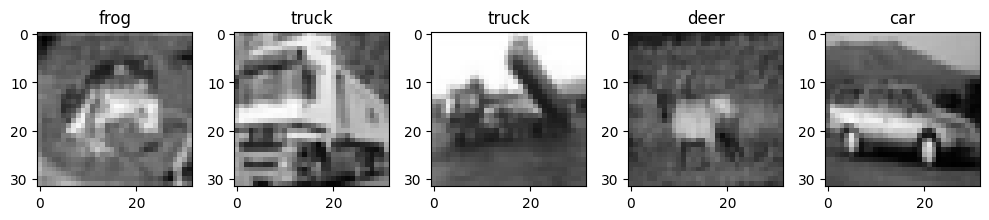

In [ ]:
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat',
           4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
# print grayscale images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(org_train[i], cmap='gray', vmin=0, vmax=255)
    plt.title(classes[y_train[i]])
plt.tight_layout()
plt.show()


**Process the input images, convert to one dimension and normalize!**

In [ ]:
#process input image
# rescale values
org_train = org_train.astype('float32') / 255.
#convert to one dimenstion
norm_x_train = org_train.reshape((len(org_train), np.prod(org_train.shape[1:])))

#normalize the input
scaler = StandardScaler()
norm_x_train = scaler.fit_transform(norm_x_train)
print(norm_x_train.shape)

(60000, 1024)


### The below function "TrainTestEval" performs the following steps:

1. Data Splitting: The function train_test_split takes in two arguments, x (features) and y (labels), and splits the data into training and testing sets using train_test_split. With 30% of the data is reserved for testing (test_size=0.3), and the remaining 70% is used for training.
The random_state=0 ensures reproducibility.

2. Model Training & Evaluation: We then initialize a Logistic Regression model with the multi_class='multinomial' option, appropriate for multi-class classification tasks.The model is trained on the x_train and y_train data using model.fit

3. Binarization of Labels: The function then uses LabelBinarizer to transform the multi-class labels (y_test) into one-hot encoded format (y_onehot_test), which is required for ROC curve calculation.

4. Plotting ROC Curve: The code creates a plot to visualize the **Receiver Operating Characteristic (ROC) curves** for each class.
For each of the 10 classes (assumed to be for a 10-class classification task, e.g., digit classification), it computes and plots the ROC curve using RocCurveDisplay.from_predictions().
The x-axis is the False Positive Rate, and the y-axis is the True Positive Rate. The title of the plot includes the type argument passed to the function, which can be used to specify the experiment or dataset.

**Summary:**
This function trains a Logistic Regression model on a multi-class classification problem, evaluates the model's accuracy, and then plots the ROC curve for each class to visualize the performance of the model across all classes.

In [ ]:
def TrainTestEval(x, y, type):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

    #using Logistic Regression
    model = LogisticRegression(max_iter=1000, multi_class='multinomial')
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)

    # binarize all class
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    _, ax = plt.subplots(figsize=(8, 8))
    # Compute ROC curve for each class

    for i in range(10):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, i],
            y_pred_proba[:, i],
            name=f"{classes[i]} ROC",
            ax=ax
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC for {type}",
    )

**Task 1: Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes.**
**Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.**


### Standard Principal Component Analysis (PCA)

------- RCA Full ---------
covered variance 0.9502323203487322 No of features 163
execution time 7.342307090759277
Model Accuracy - 0.3025


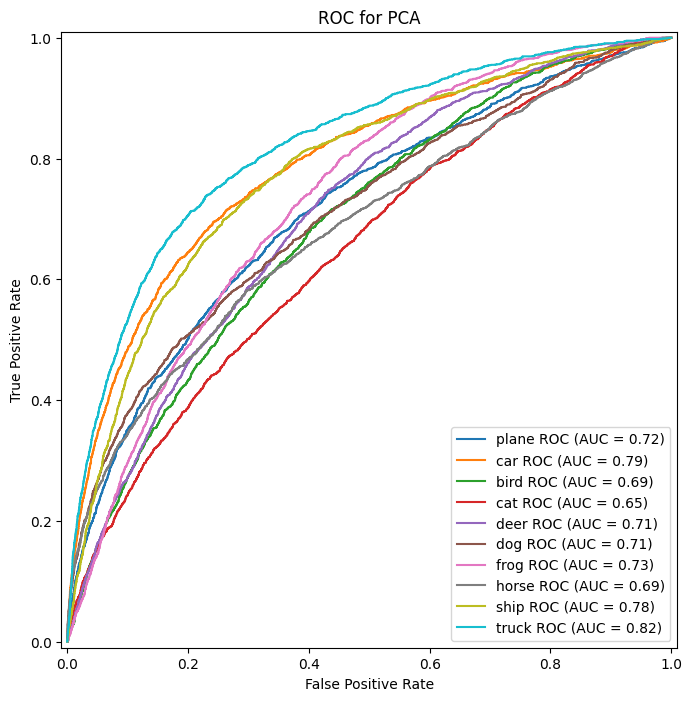

In [ ]:
# PCA with 95% energy
start_time = time.time()
pca = PCA(n_components=0.95, svd_solver='full')
pca_x_train = pca.fit_transform(norm_x_train)
print('------- RCA Full ---------')
print('covered variance', sum(pca.explained_variance_ratio_), 'No of features', pca.n_components_)
print('execution time' ,time.time()-start_time)

TrainTestEval(pca_x_train,y_train, 'PCA')


### Randomized PCA 


------ RCA Rndomized ---------
covered variance 0.9498153305321466 No of features 163
execuion time 3.6372363567352295
Model Accuracy - 0.30133333333333334


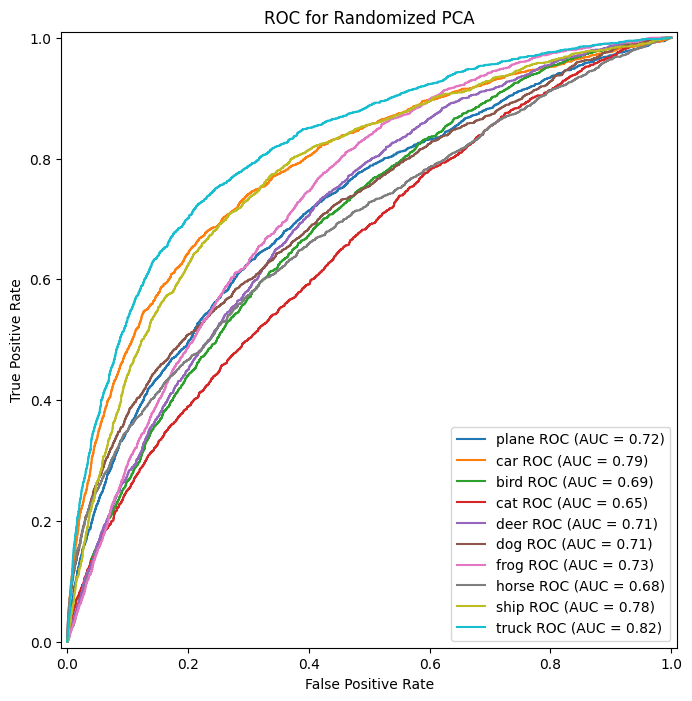

In [ ]:
# using randomized PCA for same components as PCA
start_time = time.time()
rnd_pca = PCA(n_components=pca.n_components_, svd_solver='randomized')
pca_x_train = rnd_pca.fit_transform(norm_x_train)
print('------ RCA Rndomized ---------')
print('covered variance', sum(rnd_pca.explained_variance_ratio_), 'No of features', rnd_pca.n_components_)
print('execuion time', time.time()-start_time)

TrainTestEval(pca_x_train,y_train, 'Randomized PCA')

# Observation - Same ROC with less PCA generation time

### Comparison between Standard PCA and Randomized PCA 

Standard PCA:<br>
Standard PCA uses Singular Value Decomposition (SVD) to perform dimensionality reduction. It computes the principal components exactly by decomposing the covariance matrix or using SVD on the data matrix.
SVD can be computationally expensive, especially with large datasets, as it requires calculating the full covariance matrix.

Randomized PCA:<br>
Randomized PCA (also called stochastic PCA) is an approximation of the standard PCA using a randomized algorithm. It captures same variance as standard PCA but more efficiently. 

Randomized PCA can be significantly faster, especially when dealing with high-dimensional datasets.

**Conclusion**

Randomized PCA should provide similar results in terms of variance coverage and model performance, but it does so more efficiently in terms of execution time.

Execution Time is an important factor to consider when dealing with large datasets, and Randomized PCA could be a better choice for scalability and efficiency. The results below illustrate that.

The results: <br>
    ------- RCA Full ---------
    covered variance 0.9502323203487322 No of features 163
    execution time 7.342307090759277
    
    ------ RCA Rndomized ---------
    covered variance 0.9498153305321466 No of features 163
    execution time 3.6372363567352295

**Task 2: Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.**

We then train a single layer autoencoder with linear activation function using Keras to perform unsupervised learning for dimensionality reduction, followed by training and evaluating its performance.

Few important points to note..
- The input dataset ois normalized using standard scalar
- The data (norm_x_train) is split into training and testing sets with 30% of the data reserved for testing.
- The target labels (y_train) are not used for training the autoencoder, as autoencoders are unsupervised models.
- encoding_dim is set to 163, which matches the number of principal components in the PCA model from earlier code (indicating a link between PCA and autoencoding for dimensionality reduction)
- A dense layer is used to create the encoded representation of the input, reducing the data dimensionality to encoding_dim (163). The activation function is ReLU
- A second dense layer decodes the encoded data back to the original input dimensions. The sigmoid activation function is used to output values between 0 and 1, making it suitable for normalized input data.
- The autoencoder model is created by mapping the input (input_img) to the reconstructed output (decoded).
- The model is compiled with the Adam optimizer and mean squared error (MSE) loss function. MSE is commonly used for reconstruction tasks to measure the difference between the input and its reconstruction.<br>
- We use MSE as the pixel intensity varies between 0 to 1 after grayscaling and rescaling. 
**- The autoencoder is trained using the training data (x_train) to predict its own input (since it's unsupervised). The training runs for 50 epochs with a batch size of 256, and validation data is provided as x_test (testing the reconstruction performance).**
**- The final validation loss is printed to see how well the model reconstructed the test data.**

In [ ]:
# auto encoder using single layer with linear activation
x_train, x_test, _, _ = train_test_split(norm_x_train, y_train, test_size=0.3, random_state=0)

encoding_dim = 163  # Size of encoded representations same as no of PCA components.

input_img = Input(shape=(norm_x_train.shape[1],))                   # Input image

encoded = layers.Dense(encoding_dim, activation='relu')(input_img)   # "encoded" single layer

decoded = layers.Dense(norm_x_train.shape[1], activation='sigmoid')(encoded)           # "decoded" is lossy reconstruction of  input single layer
autoencoder = Model(input_img, decoded)                        # This model maps an input to its reconstruction

autoencoder.compile(optimizer='adam', loss='mse') # binary cross entry produce negative validation loss
autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

print('Single Layer AE. Validation Loss -' , history.history['val_loss'][-1])


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 163)            │       167,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       167,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,011 (1.28 MB)

 Trainable params: 335,011 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8505 - val_loss: 0.6669
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6597 - val_loss: 0.6352
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6292 - val_loss: 0.6212
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6172 - val_loss: 0.6126
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6105 - val_loss: 0.6066
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5998 - val_loss: 0.6022
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5998 - val_loss: 0.5987
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5953 - val_loss: 0.5956
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5923 - val_loss: 0.5931
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5896 - val_loss: 0.5909
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5875 - val_loss: 0.5886
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Model Accuracy - 0.3347777777777778


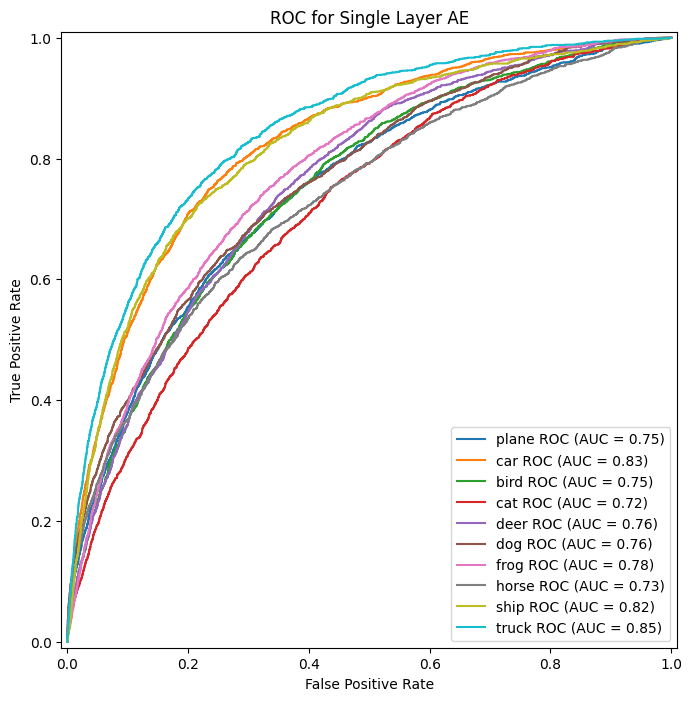

In [ ]:
#compare against PCA
model = Model(input_img, encoded)
ae_x_train = model.predict(norm_x_train)

TrainTestEval(ae_x_train, y_train, 'Single Layer AE')

#### Observation:

Better ROC: The Receiver Operating Characteristic (ROC) curve likely shows an improvement in model performance, compared to the model built from the eigen vectors from the PCA, particularly in classification tasks that may use the autoencoded features for further downstream tasks.

High Validation Loss: A high validation loss suggests that the model's reconstruction is not very accurate. This could be due to the limited capacity of the single-layer autoencoder or the choice of the sigmoid activation function, which may not capture the full complexity of the data.

#### Conclusion:
The model performs reasonably well in terms of ROC, which indicates that its learned features may still have useful patterns for downstream tasks like classification.

However, the high validation loss suggests that the autoencoder is not reconstructing the input very well, possibly due to its relatively simple architecture (single-layer). To improve the reconstruction, more complex architectures (such as multi-layer autoencoders or better activation functions) could be explored.

**Task 3: Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?**

**Now, the below code defines, trains, and evaluates a single-layer autoencoder (AE) with sigmoid activation in the encoder and ReLU activation in the decoder.**

Autoencoder Model Definition:
Encoder: The encoded layer is a Dense layer with sigmoid activation. It reduces the dimensionality of the input data to encoding_dim = 128.
Decoder: The decoded layer is another Dense layer with ReLU activation. It attempts to reconstruct the input data from the encoded representation.

**The validation loss after the final epoch is printed, providing a measure of how well the model's reconstruction matches the original data.**

In [ ]:
# auto encoder using single layer and sigmoid  activation at encoder and linear at decoder
x_train, x_test, _, _ = train_test_split(norm_x_train, y_train, test_size=0.3, random_state=0)
encoding_dim = 128
input_img = Input(shape=(norm_x_train.shape[1],))                   # Input image

encoded = layers.Dense(encoding_dim, activation='sigmoid')(input_img)   # "encoded" single layer

decoded = layers.Dense(norm_x_train.shape[1], activation='relu')(encoded)           # "decoded" is lossy reconstruction of  input single layer
autoencoder = Model(input_img, decoded)                        # This model maps an input to its reconstruction

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
print('Single Layer AE. Validation Loss -' , history.history['val_loss'][-1])


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │       132,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,296 (1.00 MB)

 Trainable params: 263,296 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8620 - val_loss: 0.7388
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7288 - val_loss: 0.7032
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6981 - val_loss: 0.6869
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6826 - val_loss: 0.6756
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6752 - val_loss: 0.6696
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6637 - val_loss: 0.6636
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6595 - val_loss: 0.6596
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6538 - val_loss: 0.6577
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6551 - val_loss: 0.6551
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6513 - val_loss: 0.6523
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6525 - val_loss: 0.6501
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

#### Comparison with Earlier Execution (Single Layer AE with Linear Activation):
**Activation Functions:**
    Earlier version: The encoder used a ReLU activation, and the decoder used a sigmoid activation.
    Current version: The encoder uses a sigmoid activation, and the decoder uses ReLU activation.

Sigmoid activation in the encoder may lead to sparse activations in the latent space, which could emphasize more distinct features.
ReLU in the decoder could provide better reconstruction results as it introduces non-linearity and allows for faster learning compared to sigmoid, but can lead to "dead neurons" if not used with proper initialization or dropout.

**Dimensionality Reduction:**
    Earlier version: The number of encoded features was determined based on the number of PCA components.
    Current version: The number of encoded features (encoding_dim = 128) is set manually without any reference to PCA, which is a choice based on empirical performance or experimentation.

**Loss Function:**
    Earlier version: The loss function was mean squared error (MSE).
    Current version: It also uses MSE, which is typical for autoencoders, as the goal is to minimize the reconstruction error.


Autoencoder Model Definition: The input is an image of size 32x32x1, indicating grayscale images with a height and width of 32 pixels.

Encoder Layers:

Encoder - Encoder uses 3 Convolution Layer with 32 , 64 and 128 filters respectively. Filter size is set as 3x3
Max Pooling with 2X2 filter is applied after each convolution layer

Convolutional layers are used to extract spatial features from the input image.
MaxPooling layers reduce the spatial dimensions of the feature maps, progressively downsampling the input data.
Activation: sigmoid is used to introduce non-linearity in the encoder.


In [ ]:
#train convolution neural net
x_train, x_test, _, _ = train_test_split(org_train, y_train, test_size=0.3, random_state=0)
input_img = Input(shape=(32,32,1))

x = layers.Conv2D(32, (3,3), activation='sigmoid', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='sigmoid', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(128, (3,3), activation='sigmoid', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x) #encoder layer
conv_encoded = layers.Conv2D(8, (2,2), padding='same')(x) #encoder layer , latent dimenstion = 8x4x4 = 128

x=  layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_encoded)
x = layers.UpSampling2D((2,2))(x)
x=  layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x=  layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
conv_decoded = layers.Conv2D(1, (3,3),activation='relu', padding='same')(x) #decoded output

conv_autoencoder = Model(input_img, conv_decoded)

conv_autoencoder.compile(optimizer='adam', loss='mse') # binary_crossentropy validation loss in negative
conv_autoencoder.summary()

history =conv_autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
print('Convolution AE. Validation Loss -' , history.history['val_loss'][-1])


: 

**Objective: The task required is to calculating and comparing the reconstruction error of a Convolutional Autoencoder (Conv-AE) with that of a single-hidden-layer autoencoder (previously implemented).**

**Reconstruction Error of Conv-AE:**
The validation loss (reconstruction error) for the Conv-AE is printed after training.This loss represents how well the convolutional autoencoder is able to reconstruct the input data.

Convolution Auto-Encoder Validation Loss - 0.008508543483912945

**Single Hidden Layer Autoencoder:**
The single hidden layer autoencoder (with sigmoid and linear activations) should have its validation loss compared to that of the Conv-AE.
The earlier loss value for this model can be retrieved from the previous runs above in this notebook, where we printed the validation loss for the single layer autoencoder.

Single Layer AE. Validation Loss (Linear) - 0.5704723000526428

Single Layer AE. Validation Loss (sigmoid)- 0.6365112066268921

### Conclusion:

Here we evaluate & conclude on how well each autoencoder performs in terms of reconstruction error. We see that the validation loss when we use a deep convolution auto encoder reduces significantly!

This signifies better reconstruction of the input image.
 
Note: (Reconstruction Error) The key measure for comparison will be the validation loss for each model.

### Reconstruction Error of Multi-Layer Autoencoder:
This task mentions that 3 hidden layers will be used, and the nodes should be distributed equally across these layers.

The key observation will be how the reconstruction error behaves as the network becomes deeper with more layers (compared to the single hidden layer version). Sigmoid activation will be used in the encoder, and linear activation will be used in the decoder (similar to earlier configurations).

Hence, We need to track the Validation loss after training the Conv-AE model for reconstruction error.

Across 20 epochs, the validation loss varies between 0.0745 on the 1st epoch and 0.0216 on the 20th epoch.


**Task 4. Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as**

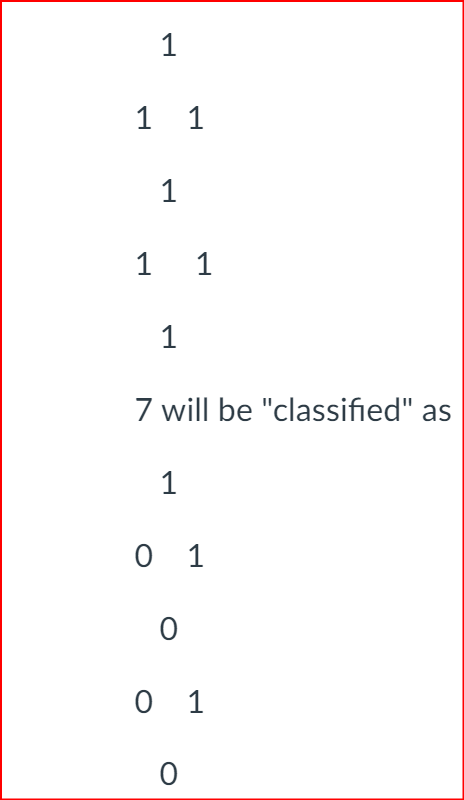

**Generate the confusion matrix for the corresponding test dataset.**

Approach:
1) Simply train CONV auto encoder for sparse feature representations which we take from the encoded layer after training. Objective is to downsample to create features and upsample to recreate same image. Since image, so use CONV layers. <br>

2) Then take encoded features to train a simple Multi-class MLP <br>
3) Finally the Prediction and Confusion matrices follow<br>

### Import the libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define seven-segment mappings for digits 0-9 as they have an intuitive mapping with images. Easy to verify.
# Using generally known segments where led's defined clockwise and the middle one is the last.
# Also the assignment instruction had incorrect example of 0 in the problem statement. Everything was 1's whereas all 1's indicate number 8, not 0.
# So using this instead.

seven_segment_mappings = {
    0: [1, 1, 1, 1, 1, 1, 0],  # 0
    1: [0, 1, 1, 0, 0, 0, 0],  # 1
    2: [1, 1, 0, 1, 1, 0, 1],  # 2
    3: [1, 1, 1, 1, 0, 0, 1],  # 3
    4: [0, 1, 1, 0, 0, 1, 1],  # 4
    5: [1, 0, 1, 1, 0, 1, 1],  # 5
    6: [1, 0, 1, 1, 1, 1, 1],  # 6
    7: [1, 1, 1, 0, 0, 0, 0],  # 7
    8: [1, 1, 1, 1, 1, 1, 1],  # 8
    9: [1, 1, 1, 1, 0, 1, 1]   # 9
}

#### Training CONV Auto Encoder

This code is designed to train a Convolutional Autoencoder (CAE) on the MNIST dataset for the task of image reconstruction
Summary of Steps in the below code..

1. Loading and Preprocessing the MNIST Dataset:
MNIST dataset is loaded with mnist.load_data(), which gives the training and test data (x_train, y_train, x_test, y_test). The pixel values of the images are normalized to the range [0, 1] by dividing the pixel values by 255.
The images are reshaped from the shape (28, 28) to (28, 28, 1) to make them suitable for convolutional layers, as these layers expect 3D inputs (height, width, channels).

2. Creating Seven-Segment Labels:
seven_segment_mappings: A predefined mapping is used to convert the MNIST digit labels (y_train and y_test) into seven-segment display equivalents. This is typically for representing the digits as they would appear on a seven-segment display (e.g., "1" becomes "0000010").
New labels (y_seven_segment_train, y_seven_segment_test) are generated using this mapping for training and testing.

3. Building the Convolutional Autoencoder:
Latent Dimension: latent_dim is set to 32, which indicates the reduced dimensionality in the encoder (this is the size of the encoding).

    Encoder:
    The input image is passed through two convolutional layers (Conv2D), each followed by a max-pooling layer (MaxPooling2D) to reduce the spatial dimensions. The encoder produces a compact representation of the input image in the encoded layer (latent space).

    Decoder:
    The decoder tries to reconstruct the original input image from the encoded representation. It uses up-sampling (UpSampling2D) and convolutional layers to gradually restore the image to its original size (28x28).
    The final output is a reconstructed image with a single channel (grayscale), which is passed through a sigmoid activation function for pixel value normalization.

4. Compiling and Training the Model:
The autoencoder model is compiled using the Adam optimizer and binary cross-entropy as the loss function. This is common for reconstruction tasks where the goal is to minimize the difference between the original and reconstructed images.
The model is trained using the training data (x_train) and validated on the test data (x_test) for 20 epochs with a batch size of 128.

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape data for convolutional layers
# This step is very important because Reshaping is needed for CONV layers
# Withput this get this error ---> ValueError: Dimensions must be equal
input_shape = (28, 28, 1)
x_train = np.reshape(x_train, (len(x_train), *input_shape))
x_test = np.reshape(x_test, (len(x_test), *input_shape))

# Create seven-segment labels
y_seven_segment_train = np.array([seven_segment_mappings[digit] for digit in y_train])
y_seven_segment_test = np.array([seven_segment_mappings[digit] for digit in y_test])

# Build the Convolutional Autoencoder
latent_dim = 32  # Reduced dimensionality

# Encoder
input_img = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
encoded = MaxPooling2D((2, 2), padding='same')(conv2)

# Decoder
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
up1 = UpSampling2D((2, 2))(conv3)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv4)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(input_img, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1777 - val_loss: 0.0731
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0729 - val_loss: 0.0700
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0698 - val_loss: 0.0679
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0682 - val_loss: 0.0677
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0672 - val_loss: 0.0661
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0665 - val_loss: 0.0656
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0660 - val_loss: 0.0651
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0655 - val_loss: 0.0649
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0652 - val_loss: 0.0645
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0650 - val_loss: 0.0642
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0647 - val_loss: 0.0640

**Observation:**

Since val_loss decreasing slowly at the end, don't need more epochs, or else it may overfit. However, reshaping input data is necessary.

#### Building MLP

The below code builds a feature extraction model using an encoder from a convolutional autoencoder and then trains a Multilayer Perceptron (MLP) classifier for multi-label classification

Key Points
- The encoder model extracts meaningful features from the raw MNIST images, which are then used as input to the MLP classifier.
- The MLP classifier is designed for multi-label classification, which is suitable for predicting multiple labels simultaneously (likely for multi-digit representations).
- The ReLU activation in the hidden layers helps the model learn complex patterns, while sigmoid activation at the output layer allows for multi-label classification, where each label is independent.
- Binary cross-entropy loss function is used since the task involves predicting the presence (or absence) of each label independently.


In [4]:
# Build the encoder model to extract features
encoder = Model(input_img, encoded)

# Extract features from the training and testing data
encoded_input_shape = encoder.output_shape[1:]
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# Flatten the encoded features for the MLP
x_train_features = x_train_encoded.reshape(x_train_encoded.shape[0], -1)
x_test_features = x_test_encoded.reshape(x_test_encoded.shape[0], -1)

# Build the MLP classifier
mlp_input_shape = x_train_features.shape[1]
mlp_output_shape = 7

mlp_input = Input(shape=(mlp_input_shape,))
dense1 = Dense(128, activation='relu')(mlp_input)
dense2 = Dense(64, activation='relu')(dense1)
output_layer = Dense(mlp_output_shape, activation='sigmoid')(dense2) # Sigmoid for multi-label

mlp_classifier = Model(mlp_input, output_layer)

# Compile the MLP classifier
mlp_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])

# Train the MLP classifier
mlp_classifier.fit(x_train_features, y_seven_segment_train,
                   epochs=20,
                   batch_size=128,
                   shuffle=True,
                   validation_split=0.2)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2271 - val_loss: 0.0589
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0587 - val_loss: 0.0469
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - val_loss: 0.0326
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0331 - val_loss: 0.0292
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0269 - val_loss: 0.0256
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0240 - val_loss: 0.0242
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214 - val_loss: 0.0353
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0208 - val_loss: 0.0267
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0169 - val_loss: 0.0243
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0240
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - 

## Good overall accuracy of 96% and confusion matrices look good

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


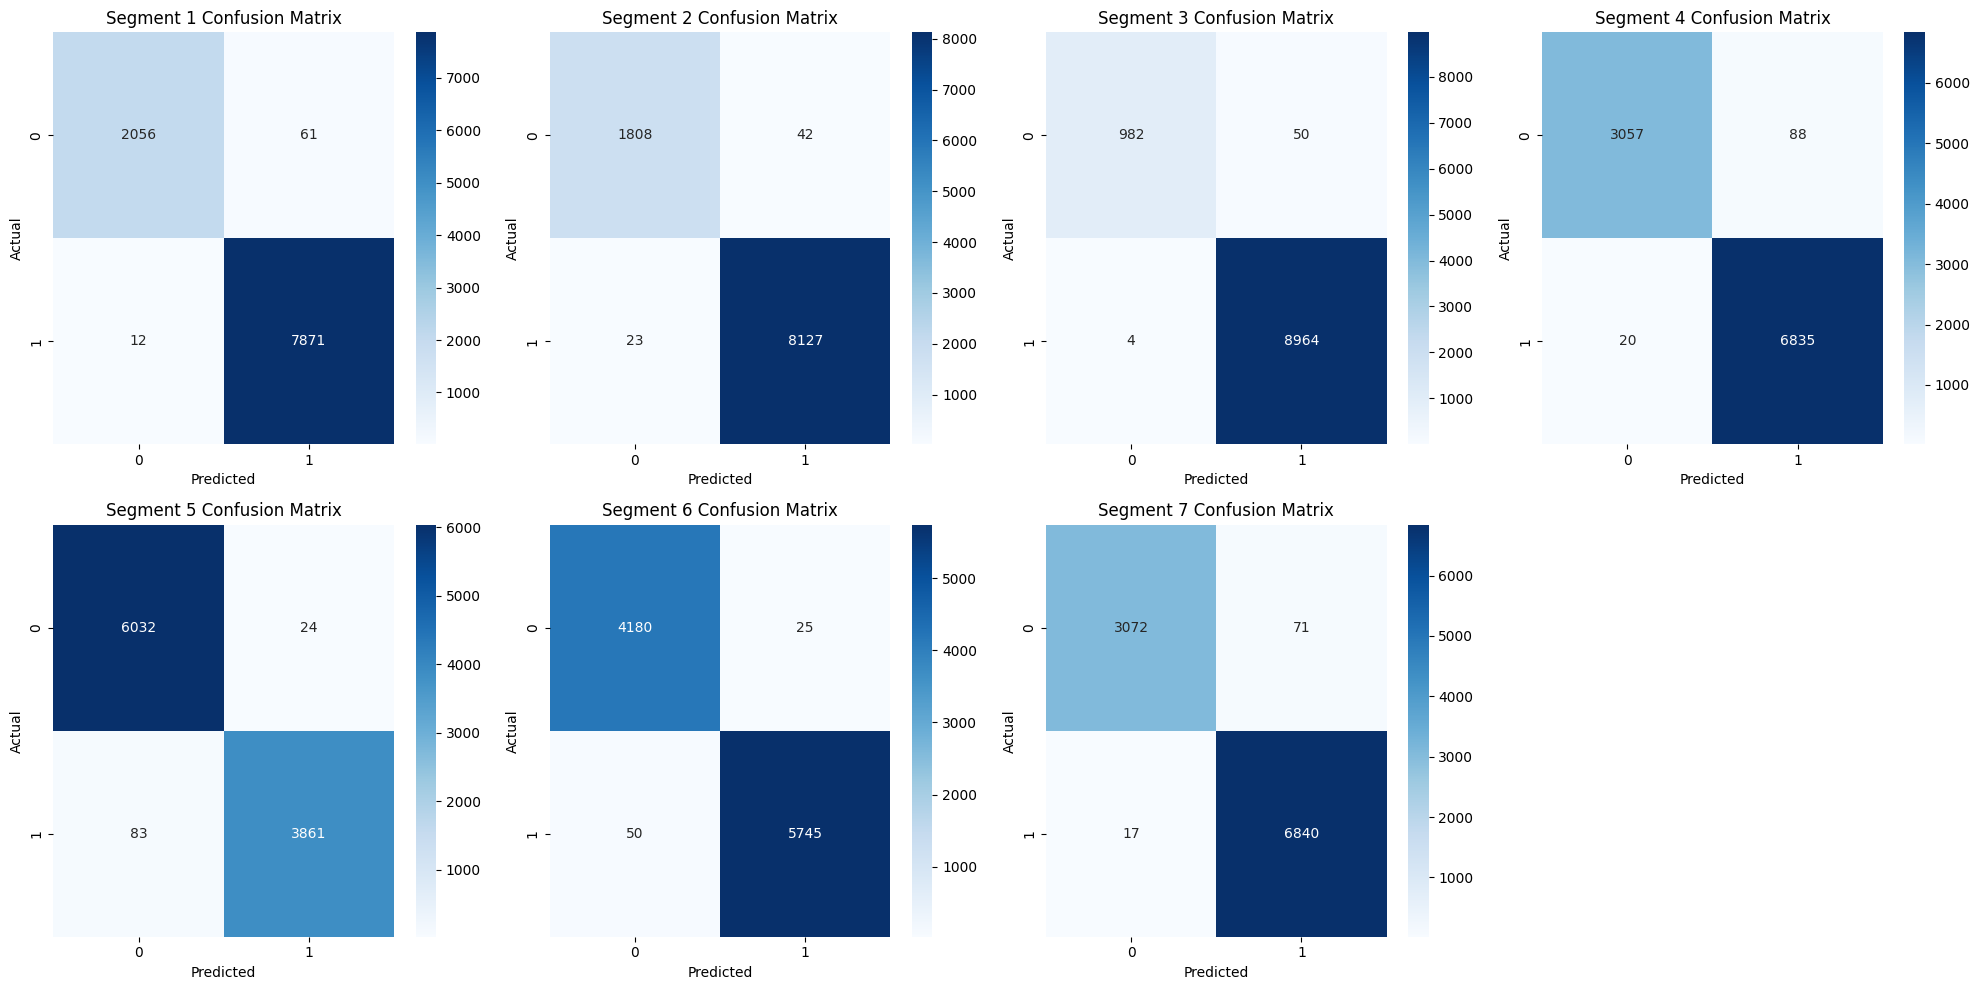

Overall Accuracy: 0.9658


In [5]:
# Make predictions on the test set
predictions = mlp_classifier.predict(x_test_features)

# Threshold the predictions to get binary outputs (0 or 1 for each segment)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the confusion matrix for each segment
confusion_matrices = []
for i in range(mlp_output_shape):
    cm = confusion_matrix(y_seven_segment_test[:, i], binary_predictions[:, i])
    confusion_matrices.append(cm)

# Plot the confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Flatten the 2D array to 1D for easier indexing

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'],
                ax=axes[i])
    axes[i].set_title(f'Segment {i+1} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide the last subplot (since we only have 7 matrices)
axes[-1].remove()

plt.tight_layout()
plt.show()

# Calculate overall accuracy (you can define this differently based on your needs)
correct_predictions = np.all(binary_predictions == y_seven_segment_test, axis=1)
overall_accuracy = np.mean(correct_predictions)
print(f"Overall Accuracy: {overall_accuracy:.4f}")